This notebook provides a session setup template. 
Includes gradual memory allocation setup (able to comment-out without hinderance if needed). 
Add modules as needed. 

Use: FILE -> Make A Copy... -> Rename your new file -> have fun experimenting with TF!

In [109]:
try:
    # Aarons additions
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import MinMaxScaler
    plt.style.use('fivethirtyeight')
    # Import modules
    from keras.backend import tensorflow_backend as tb
    from sklearn.model_selection import train_test_split
    import keras as k
    import numpy as np
    import os
    import pandas as pd
    import tensorflow as tf
    # Set up resizable memory: this code will allow gradual memory allocation instead of
    #     trying to allocate something like 4GB at once on your video card
    random_seed = 1 # Random seed included for reproducability/consistency reasons when learning. Change as necessary.
    np.random.seed(random_seed)
    if tb._SESSION is None:
        if not os.environ.get('OMP_NUM_THREADS'):
            config = tf.ConfigProto(allow_soft_placement=True)
        else:
            num_thread = int(os.environ.get('OMP_NUM_THREADS'))
            config = tf.ConfigProto(intra_op_parallelism_threads=num_thread, allow_soft_placement=True)
        config.gpu_options.allow_growth=True
        _SESSION = tf.Session(config=config)
    session = _SESSION
    print('Session setup successful!')
except Exception as e:
    print('Session setup failed:')
    raise e

Session setup successful!


In [125]:
# Some functions to help out with
def plot_predictions(test,predicted,stock='IBM') -> None:
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(stock + ' Stock Price')
    plt.legend()
    plt.show()

# Aaron uses this to set the size of things on his high dpi display.
# ... stupid scaling issues.
def plot_this(*args, **kwargs):
    plt.rcParams.update({'font.size': 30})
    fig, ax = plt.subplots()
    fig.set_size_inches(30,25)
    # Future work, for legends: https://stackoverflow.com/a/4701285/11385910
    plt.plot(*args, **kwargs)
    
def return_rmse(test,predicted) -> None:
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [111]:
stock_data_path = '../data/stock-time-series-20050101-to-20171231/'
os.listdir(stock_data_path)[:5]

['AABA_2006-01-01_to_2018-01-01.csv',
 'AAPL_2006-01-01_to_2018-01-01.csv',
 'all_stocks_2006-01-01_to_2018-01-01.csv',
 'all_stocks_2017-01-01_to_2018-01-01.csv',
 'AMZN_2006-01-01_to_2018-01-01.csv']

In [126]:
# First, we get the data
dataset = pd.read_csv(stock_data_path + 'IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
print("Number of entries in dataframe:", len(dataset))
dataset.head(3)

Number of entries in dataframe: 3020


,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM


In [113]:
# Siddarth: Checking for missing values (K: ??? This doesn't do any null checking AFAIK!)
#                                    1:2 is high column...
# .values converts to np array,

# We use this criptic method since simply indexing with 1 would give us
# a 1 dim array, and... transpose() on a 1 dim numpy array does nothing!
# (and we want a column vector)
# Ultimately, this should be easier to work with and change later.
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

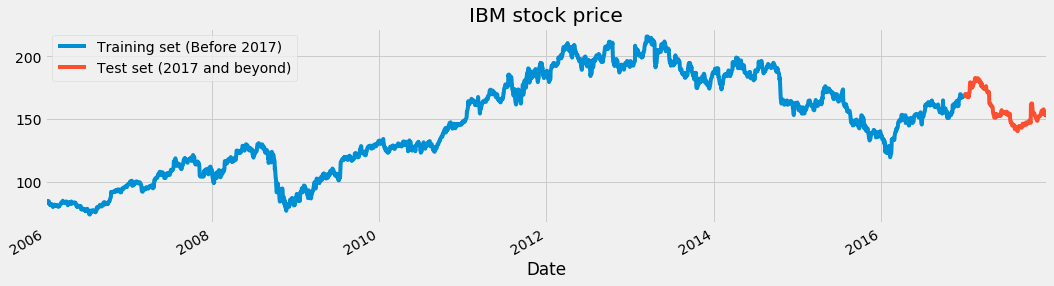

In [114]:
# Siddarth: "We have chosen 'High' attribute for prices. Let's see what it looks like"
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [124]:
# Scaling the training set
# 
# MinMaxScaler scales all data features individually between the ranges
# given.  It uses the known min and max.
#
# Problem: We are scaling between some arbitrary 'min' and 'max' values 
#          that are completely dependent on when we start and stop our
#          training set.  Shouldn't the min be 0 and the 'max' just be 
#          a soft suggestion for scale, as opposed to a hard ceiling?
#          As it stands we can not predict anything outside of the prev
#          range experienced by the stock.
#          NOTE: For our current dataset, all the right answers are in
#                the range 0,1 (after scaling)
#       Idea: Set 0 to $0, and, can we have a floating maximum based on
#             SEC imposed daily maximum? Does that make any sense to try
#             and do?  On second thought, I don't think this would be 
#             very practical.  
sc = MinMaxScaler(feature_range=(0,1))  # default is (0,1)
training_set_scaled = sc.fit_transform(training_set)
# def sc.fit_transform(X, y=None, **fit_params)
#   So what are fit_params? And what does it mean when we have y=None?
#   If we had y!=None, then the range for fitting would be mad larger
#   if necessary. (I think)

In [115]:
%qtconsole 